In [2]:
%load_ext autoreload
%autoreload 2

from montlake.atomgeom.features import get_features,get_D_feats_feats
from montlake.atomgeom.utils import get_atoms_4
from montlake.simulations.rigidethanol import get_rigid_ethanol_data
from montlake.utils.utils import get_234_indices, get_atoms3_full, get_atoms4_full, data_stream_custom_range, get_cosines
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.gradients.estimate import get_grads_pullback
from montlake.statistics.normalization import normalize_L212
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.optimization.utils import get_selected_function_ids,get_selected_functions_lm2
from montlake.utils.replicates import Replicate, get_supports_brute
from montlake.plotting.manifolds import plot_manifold_3d,plot_manifold_featurespace
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_norm, plot_watch_custom
from megaman.embedding import SpectralEmbedding
from montlake.statistics.supportrecovery import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max

import pandas as pd
import dill as pickle
import os
import sys
import numpy as np
import itertools
from itertools import permutations,combinations
from sklearn.decomposition import TruncatedSVD
import pathos
from pathos.multiprocessing import ProcessingPool as Pool

In [3]:
infile = '/Users/samsonkoelle/thesis_data/processed_data_2/malonaldehyde/mal_full_mfresults_mflasso'
with open(infile,'rb') as inp:
    results = pickle.load(inp, pickle.HIGHEST_PROTOCOL)

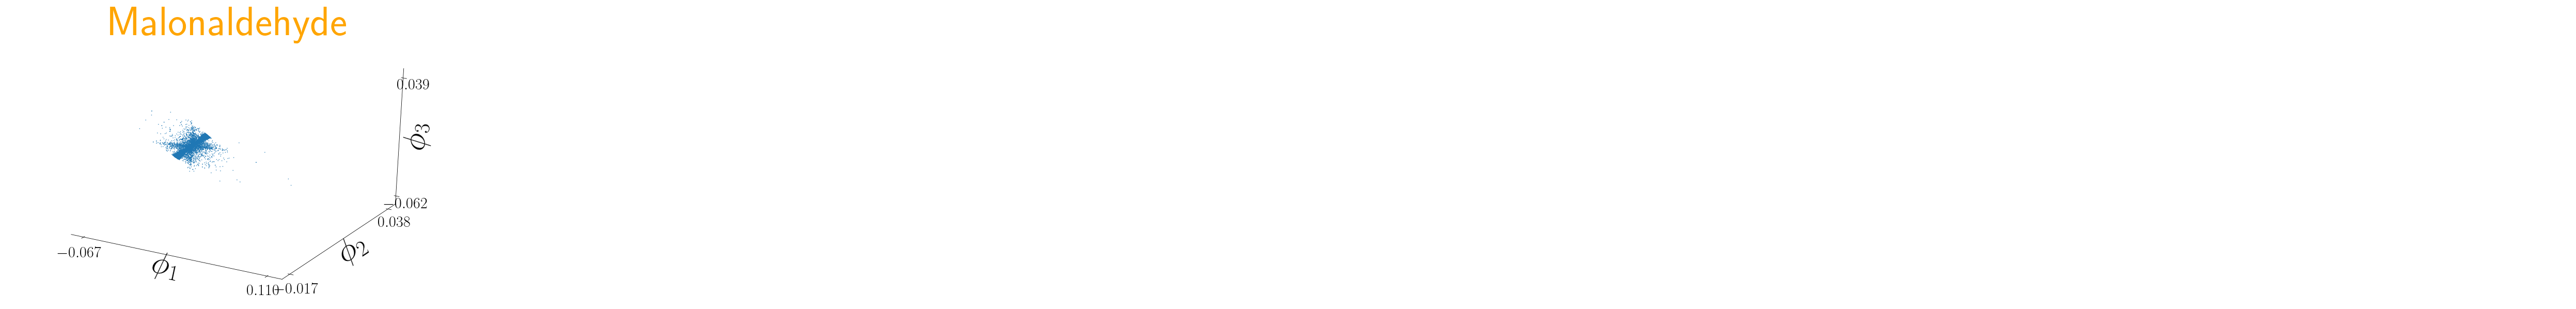

In [4]:
alpha = 1
s = 1
title = 'Malonaldehyde'
n = 50000
colors = np.vstack([np.hstack(results['selected_function_values'][i]) for i in range(n)])
c= colors[:,0]
embed = results['embed']
plot_manifold_3d(embed, s, alpha, c, title)#from montlake.plotting.manifold import plot_manifold

0
1
2
3
4
5


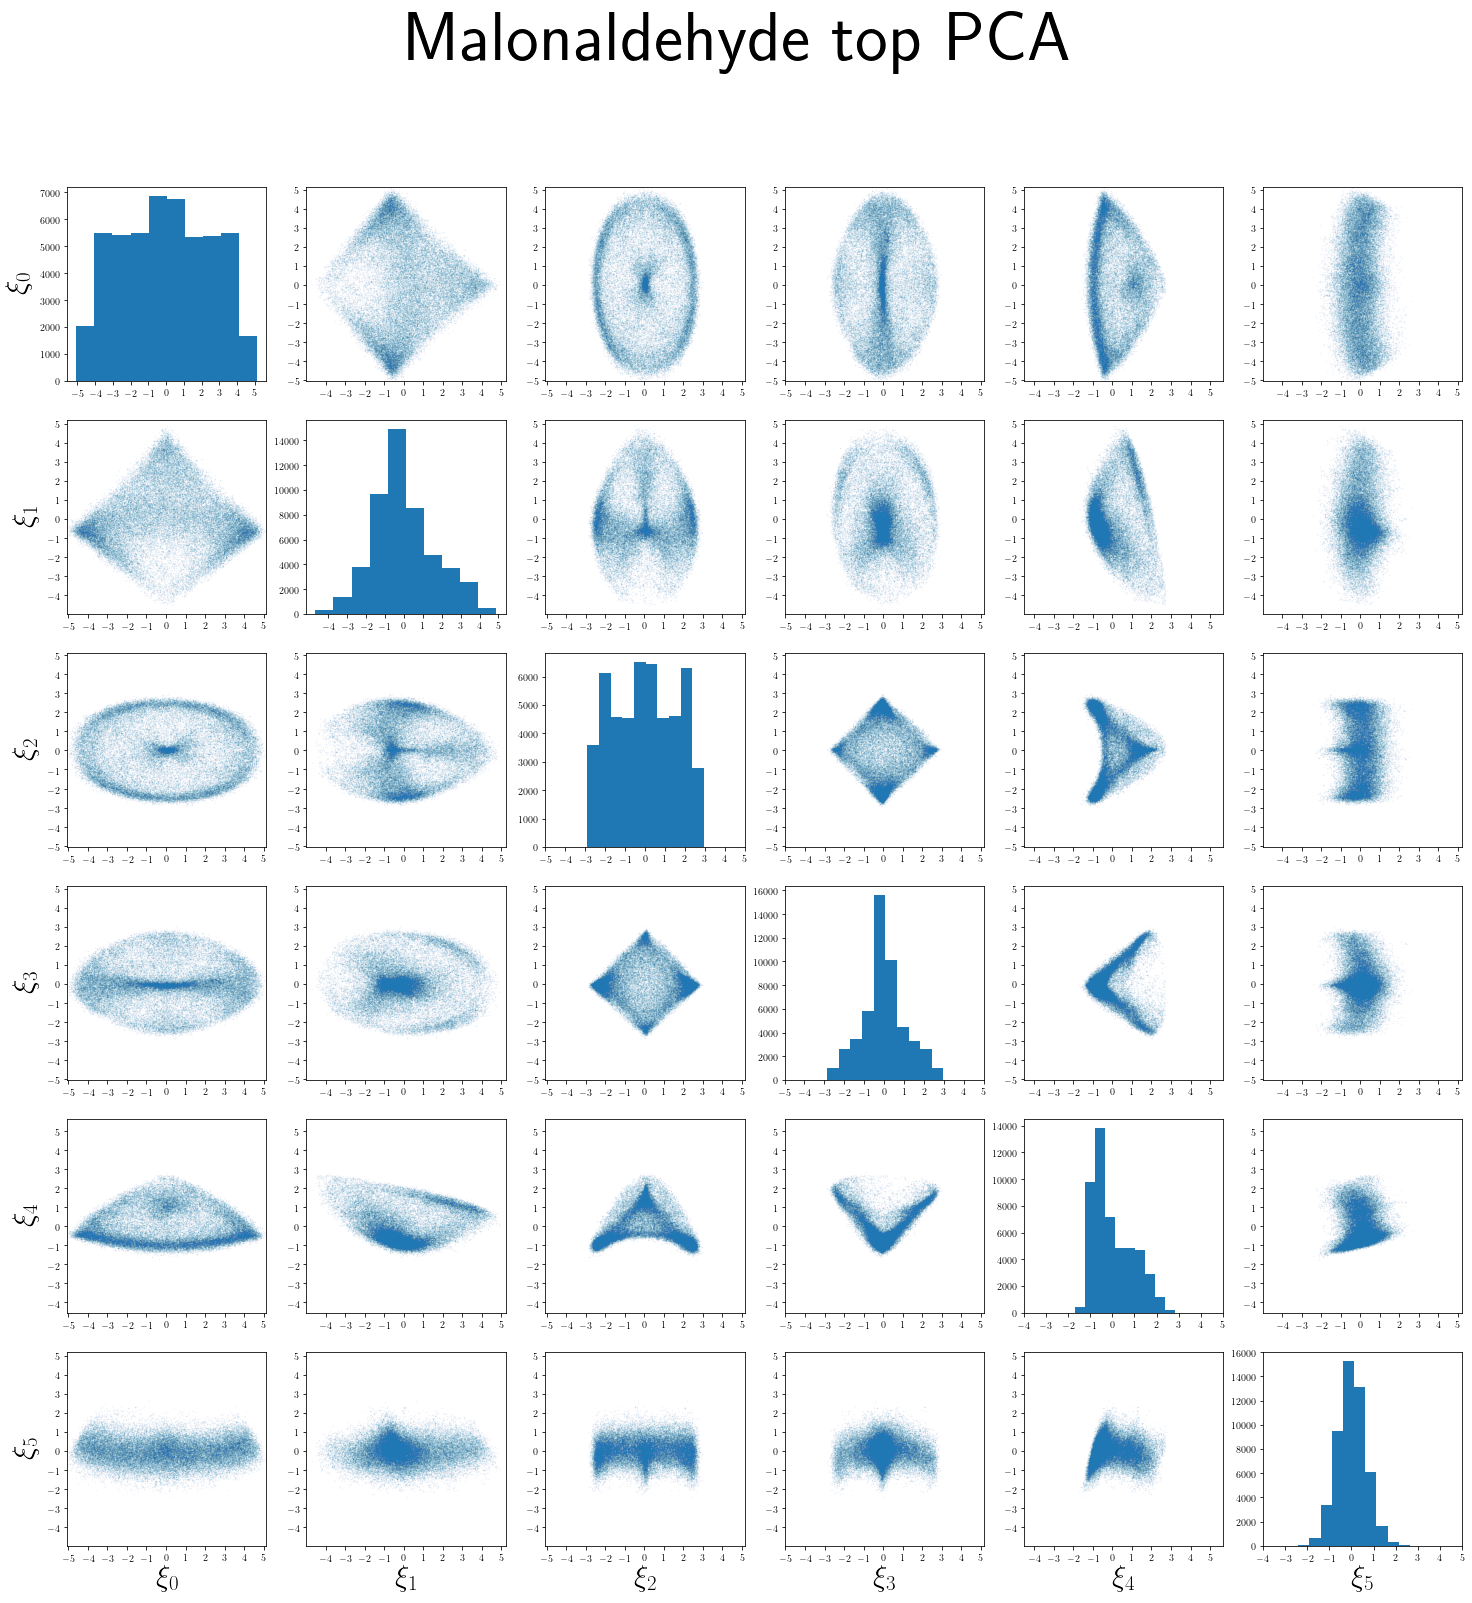

In [5]:
#i = 0
data = results['data']
title = 'Malonaldehyde top PCA'
ncord = 6
plot_manifold_featurespace(data,title,ncord)

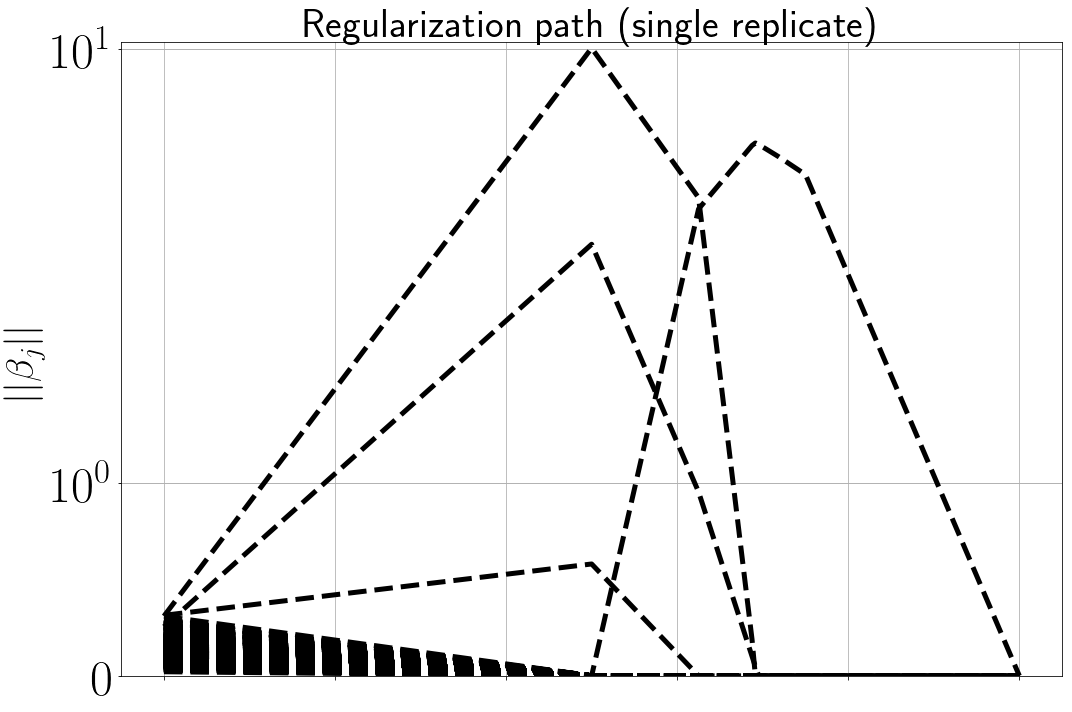

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes_all = plt.subplots(figsize=(15, 10))

#colors = np.hstack([np.repeat('orange',6), np.repeat('blue',6)])
#plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig,colors)#axes_all[0].imshow(asdf)
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig, colors = np.repeat('black',756))#axes_all[0].imshow(asdf)

axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
axes_all.set_xticklabels([])
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/tol30_replicate')

In [25]:
#compute embedding
#compute geometry
radius= 1.
n_neighbors= 1000
data = results['data']
geom = get_geom(data, radius, n_neighbors) 


In [26]:
spectral_embedding = SpectralEmbedding(n_components=3,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [27]:
data = embed_spectral
s = 1
alpha = .1

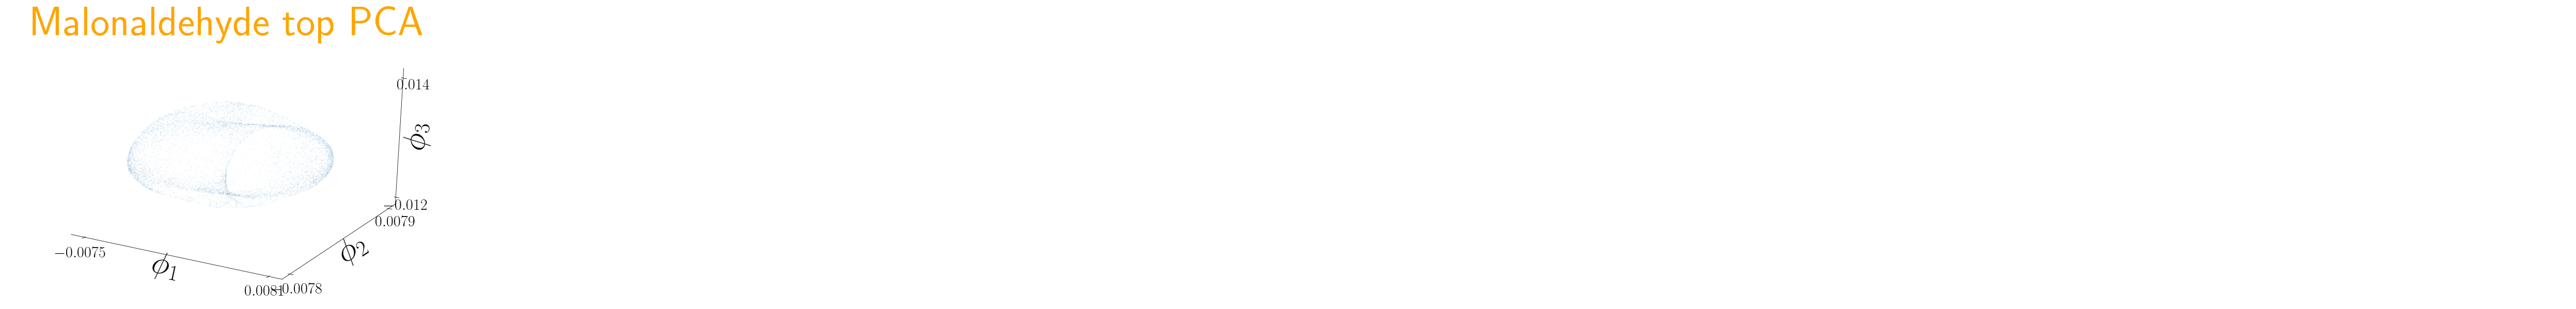

In [28]:
    %matplotlib inline
    fig, axs = plt.subplots(1,1, figsize = (15,10))
    axs.set_axis_off()

    selected_points = list(range(10000))
    x = data[:, 0][selected_points]
    y = data[:, 1][selected_points]
    z = data[:, 2][selected_points]

    ax = fig.add_subplot(1,1,1, projection='3d')

    #ax.scatter(x, y, z, c = g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.scatter(x, y, z, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize = 60)
    ax.set_ylabel(r'$\phi_2$', fontsize = 60)
    ax.set_zlabel(r'$\phi_3$', fontsize = 60)

    ax.set_title(title, fontsize = 80, color = 'orange')
    #ax.set_title(r'$g_{1}$', fontsize = 80, color = 'orange')

    xmin = np.float(np.format_float_positional(data[:, 0][selected_points].min(), precision=2, fractional=False))
    xmax = np.float(np.format_float_positional(data[:, 0][selected_points].max(), precision=2, fractional=False))
    ymin = np.float(np.format_float_positional(data[:, 1][selected_points].min(), precision=2, fractional=False))
    ymax = np.float(np.format_float_positional(data[:, 1][selected_points].max(), precision=2, fractional=False))
    zmin = np.float(np.format_float_positional(data[:, 2][selected_points].min(), precision=2, fractional=False))
    zmax = np.float(np.format_float_positional(data[:, 2][selected_points].max(), precision=2, fractional=False))
    ax.set_xticks([xmin, xmax])
    ax.set_yticks([ymin, ymax])
    ax.set_zticks([zmin, zmax])
    ax.tick_params(labelsize=30)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

In [16]:
diffusion_time = 0.05
#diffusion_time = 1
dim = 2
import numpy as np
(diffusion_time * (diffusion_time * np.pi * 4)**(dim/2))**(0.5)

0.1772453850905516